### Objective

In this notebook, we will use AutoML library to address the NSL-KDD dataset

### 1. Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

#### 1.1 Load dataset

In [2]:
# import train data
train = pd.read_csv('dataset/train_AutoML_probe.csv')
train.rename(columns={'attack_category': 'attack'}, inplace=True)

# import test data
test = pd.read_csv('dataset/test_AutoML_probe.csv')
test.rename(columns={'attack_category': 'attack'}, inplace=True)

#### 1.2 Feature category

In [3]:
feature_names = defaultdict(list)
with open('dataset/feature_types.txt', 'r') as f:
    for line in f.readlines():
        feature, category = line.strip().strip('.').split(': ')
        feature_names[category].append(feature)

# continuous features
continuous_features = feature_names['continuous']
continuous_features.remove('num_outbound_cmds')

# binary features
binary_features = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']

# nominal features
nominal_features = list(set(feature_names['discrete'])-set(binary_features))

#### 1.3 Ordinal encoding

In [4]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
train[nominal_features] = enc.fit_transform(train[nominal_features])
test[nominal_features] = enc.transform(test[nominal_features])

# Separate feature/label
X_train, y_train = train.iloc[:, :-1].to_numpy(), train.iloc[:, -1].to_numpy()
X_test, y_test = test.iloc[:, :-1].to_numpy(), test.iloc[:, -1].to_numpy()

### 2. ML modeling

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    accuracy_score, 
    roc_auc_score,
    f1_score,
    matthews_corrcoef
)


def metrics_display(y_test, y_pred, y_pred_proba):

    # Obtain confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Output classification metrics
    tn, fp, fn, tp = cm.ravel()
    
    print(f'ROC_AUC score: {roc_auc_score(y_test, y_pred_proba):.3f}')
    print(f'f1 score: {f1_score(y_test, y_pred):.3f}')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')
    print(f'Precision: {precision_score(y_test, y_pred)*100:.2f}%')
    print(f'Detection rate: {recall_score(y_test, y_pred)*100:.2f}%')
    print(f'False alarm rate: {fp / (tn+fp)*100}%')
    print(f'MCC: {matthews_corrcoef(y_test, y_pred):.2f}')
    
    # Display confusion matrix
    # ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format='.5g', colorbar=False)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

#### 2.1 Default XGBoost model

In [ ]:
%%time
import xgboost as xgb
clf_xgb = xgb.XGBClassifier(eval_metric='auc', 
                            max_depth=4,
                            learning_rate=0.3,
                            reg_lambda=50,
                            gamma=5,
                            subsample=1,
                            colsample_bytree=1,
                            use_label_encoder=False,
                            scale_pos_weight=50,
                            n_jobs=-1,
                            seed=42)

clf_xgb.fit(X_train, y_train)

y_pred = clf_xgb.predict(X_test)
y_pred_proba = clf_xgb.predict_proba(X_test)[:, 1]
metrics_display(y_test, y_pred, y_pred_proba)

#### 2.2 AutoML with FLAML

In [6]:
from flaml import AutoML
automl = AutoML()
automl.fit(X_train, y_train, task="classification", time_budget=3600, estimator_list=['xgboost'],
          log_file_name='automl.log', log_type='best')

[flaml.automl: 09-16 17:46:28] {2373} INFO - task = classification
[flaml.automl: 09-16 17:46:28] {2375} INFO - Data split method: stratified
[flaml.automl: 09-16 17:46:28] {2379} INFO - Evaluation method: cv
[flaml.automl: 09-16 17:46:28] {2448} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 09-16 17:46:28] {2586} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl: 09-16 17:46:28] {2878} INFO - iteration 0, current learner xgboost
[flaml.automl: 09-16 17:46:29] {3008} INFO - Estimated sufficient time budget=14005s. Estimated necessary time budget=14s.
[flaml.automl: 09-16 17:46:29] {3055} INFO -  at 1.5s,	estimator xgboost's best error=0.0139,	best estimator xgboost's best error=0.0139
[flaml.automl: 09-16 17:46:29] {2878} INFO - iteration 1, current learner xgboost
[flaml.automl: 09-16 17:46:30] {3055} INFO -  at 2.1s,	estimator xgboost's best error=0.0074,	best estimator xgboost's best error=0.0074
[flaml.automl: 09-16 17:46:30] {2878} INFO - iteration 2, 

[flaml.automl: 09-16 17:49:09] {2878} INFO - iteration 35, current learner xgboost
[flaml.automl: 09-16 17:50:39] {3055} INFO -  at 250.9s,	estimator xgboost's best error=0.0000,	best estimator xgboost's best error=0.0000
[flaml.automl: 09-16 17:50:39] {2878} INFO - iteration 36, current learner xgboost
[flaml.automl: 09-16 17:50:41] {3055} INFO -  at 253.0s,	estimator xgboost's best error=0.0000,	best estimator xgboost's best error=0.0000
[flaml.automl: 09-16 17:50:41] {2878} INFO - iteration 37, current learner xgboost
[flaml.automl: 09-16 17:50:52] {3055} INFO -  at 264.9s,	estimator xgboost's best error=0.0000,	best estimator xgboost's best error=0.0000
[flaml.automl: 09-16 17:50:52] {2878} INFO - iteration 38, current learner xgboost
[flaml.automl: 09-16 17:51:17] {3055} INFO -  at 289.0s,	estimator xgboost's best error=0.0000,	best estimator xgboost's best error=0.0000
[flaml.automl: 09-16 17:51:17] {2878} INFO - iteration 39, current learner xgboost
[flaml.automl: 09-16 17:51:41

[flaml.automl: 09-16 18:14:08] {2878} INFO - iteration 72, current learner xgboost
[flaml.automl: 09-16 18:14:34] {3055} INFO -  at 1686.6s,	estimator xgboost's best error=0.0000,	best estimator xgboost's best error=0.0000
[flaml.automl: 09-16 18:14:34] {2878} INFO - iteration 73, current learner xgboost
[flaml.automl: 09-16 18:15:18] {3055} INFO -  at 1730.2s,	estimator xgboost's best error=0.0000,	best estimator xgboost's best error=0.0000
[flaml.automl: 09-16 18:15:18] {2878} INFO - iteration 74, current learner xgboost
[flaml.automl: 09-16 18:15:37] {3055} INFO -  at 1749.2s,	estimator xgboost's best error=0.0000,	best estimator xgboost's best error=0.0000
[flaml.automl: 09-16 18:15:37] {2878} INFO - iteration 75, current learner xgboost
[flaml.automl: 09-16 18:16:38] {3055} INFO -  at 1810.3s,	estimator xgboost's best error=0.0000,	best estimator xgboost's best error=0.0000
[flaml.automl: 09-16 18:16:38] {2878} INFO - iteration 76, current learner xgboost
[flaml.automl: 09-16 18:1

[flaml.automl: 09-16 18:37:04] {2878} INFO - iteration 109, current learner xgboost
[flaml.automl: 09-16 18:37:25] {3055} INFO -  at 3057.7s,	estimator xgboost's best error=0.0000,	best estimator xgboost's best error=0.0000
[flaml.automl: 09-16 18:37:25] {2878} INFO - iteration 110, current learner xgboost
[flaml.automl: 09-16 18:37:51] {3055} INFO -  at 3083.9s,	estimator xgboost's best error=0.0000,	best estimator xgboost's best error=0.0000
[flaml.automl: 09-16 18:37:51] {2878} INFO - iteration 111, current learner xgboost
[flaml.automl: 09-16 18:37:56] {3055} INFO -  at 3088.8s,	estimator xgboost's best error=0.0000,	best estimator xgboost's best error=0.0000
[flaml.automl: 09-16 18:37:56] {2878} INFO - iteration 112, current learner xgboost
[flaml.automl: 09-16 18:39:33] {3055} INFO -  at 3185.4s,	estimator xgboost's best error=0.0000,	best estimator xgboost's best error=0.0000
[flaml.automl: 09-16 18:39:33] {2878} INFO - iteration 113, current learner xgboost
[flaml.automl: 09-16

ROC_AUC score: 0.980
f1 score: 0.803
Accuracy: 92.79%
Precision: 88.28%
Detection rate: 73.67%
False alarm rate: 2.4405313561940067%
MCC: 0.76


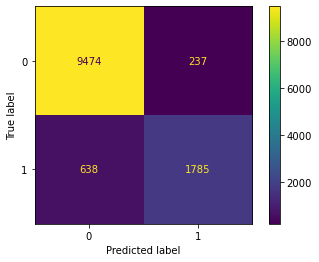

In [7]:
y_pred = automl.predict(X_test)
y_pred_proba = automl.predict_proba(X_test)[:, 1]
metrics_display(y_test, y_pred, y_pred_proba)

#### 2.3 Develop AutoML API

In [ ]:
opt = {}

In [ ]:
custom_hp = {
         "learning_rate": {
             "domain": tune.loguniform(lower=0.01, upper=20.0),
             "init_value": 1
         }
}

In [ ]:
from langchain.tools import tool
from flaml import tune
from flaml import AutoML

@tool("AutoML-LightGBM")
def auto_machine_learning(time_budget: float, metric: str, custom_hp: dict) -> str:
    """Hyperparameter tuning with FLAML library. The tunable hyperparameters for LightGBM are: 
    n_estimators, num_leaves, min_child_samples, learning_rate, 
    log_max_bin (logarithm of (max_bin + 1) with base 2), 
    colsample_bytree, reg_alpha, reg_lambda.
    
    Args:
    ------
    time_budget: A float number of the time budget in seconds.
    metric: The optimization metric. 
            Built-in metric:
                'accuracy': 1 - accuracy as the corresponding metric to minimize.
                'roc_auc': minimize 1 - roc_auc_score. 
                'f1': minimize 1 - f1_score.
            User-defined function:
                A customized metric function that requires the following (input) signature, and returns the input 
                config’s value in terms of the metric you want to minimize, and a dictionary of auxiliary information 
                at your choice:
                
                    def custom_metric(
                        X_val, y_val, estimator, labels,
                        X_train, y_train, weight_val=None, weight_train=None,
                        config=None, groups_val=None, groups_train=None,
                    ):
                        return metric_to_minimize, metrics_to_log
                        
                For example:
                
                    def custom_metric(
                        X_val, y_val, estimator, labels,
                        X_train, y_train, weight_val=None, weight_train=None,
                        *args,
                    ):
                        from sklearn.metrics import log_loss
                        import time

                        start = time.time()
                        y_pred = estimator.predict_proba(X_val)
                        pred_time = (time.time() - start) / len(X_val)
                        val_loss = log_loss(y_val, y_pred, labels=labels, sample_weight=weight_val)
                        y_pred = estimator.predict_proba(X_train)
                        train_loss = log_loss(y_train, y_pred, labels=labels, sample_weight=weight_train)
                        alpha = 0.5

    custom_hp: The custom search space specified by user.It is a nested dict with keys being hyperparameter names, 
               and values are dicts of info ("domain" and "init_value") about the search space associated with the 
               hyperparameter.
               
               
               See the example below for the commonly used types of domains.
               
                # Sample a float uniformly between -5.0 and -1.0
                tune.uniform(-5, -1),

                # Sample a float uniformly between 3.2 and 5.4,
                # rounding to increments of 0.2
                tune.quniform(3.2, 5.4, 0.2),

                # Sample a float uniformly between 0.0001 and 0.01, while
                # sampling in log space
                tune.loguniform(1e-4, 1e-2),

                # Sample a float uniformly between 0.0001 and 0.1, while
                # sampling in log space and rounding to increments of 0.00005
                tune.qloguniform(1e-4, 1e-1, 5e-5),

                # Sample a random float from a normal distribution with
                # mean=10 and sd=2
                tune.randn(10, 2),

                # Sample a random float from a normal distribution with
                # mean=10 and sd=2, rounding to increments of 0.2
                tune.qrandn(10, 2, 0.2),

                # Sample a integer uniformly between -9 (inclusive) and 15 (exclusive)
                tune.randint(-9, 15),

                # Sample a random uniformly between -21 (inclusive) and 12 (inclusive (!))
                # rounding to increments of 3 (includes 12)
                tune.qrandint(-21, 12, 3),

                # Sample a integer uniformly between 1 (inclusive) and 10 (exclusive),
                # while sampling in log space
                tune.lograndint(1, 10),

                # Sample a integer uniformly between 2 (inclusive) and 10 (inclusive (!)),
                # while sampling in log space and rounding to increments of 2
                tune.qlograndint(2, 10, 2),
                
                # Sample an option uniformly from the specified choices
                tune.choice(["a", "b", "c"])  

                
    Outputs:
    --------
    record: log of tuning process, including the tuning history and the currently found 
            best configurations.
    """
    
    # AutoML object
    automl = AutoML()
    
    # Tuning config
    config = {
        'task': 'classification',
        'metric': metric,
        'time_budget': time_budget,
        'estimator_list': ['lgbm'],
        'custom_hp': {'lgbm': custom_hp},
        'log_file_name': 'automl.log',
    }
    
    # Fitting
    automl.fit(X_train, y_train, **config)
    opt['model'] = automl
    
    # Tuning logs
    with open("automl.log", "r") as txt_file:
        log = txt_file.readlines()
    record = {
        'log': log,
        'best config': automl.best_config
    }
    
    return record

#### Test API

In [ ]:
from flaml import tune
time_budget = 10
metric = 'accuracy'
    
custom_hp = {
         "learning_rate": {
             "domain": tune.loguniform(lower=0.01, upper=1),
             "init_value": 0.1
         }
}

In [ ]:
record = auto_machine_learning(time_budget, metric, custom_hp)

#### 2.4 Dataframe profiling

In [ ]:
def data_characteristics_report(df, num_feats, bin_feats, nom_feats):
    
    # Last column is the label
    target = df.iloc[:, -1]
    features = df.iloc[:, :-1]

    # General dataset info
    num_instances = len(df)
    num_features = features.shape[1]

    # Label class analysis
    class_counts = target.value_counts()
    class_distribution = class_counts/num_instances
    if any(class_distribution<0.3) or any(class_distribution>0.7):
        class_imbalance = True
    else:
        class_imbalance = False
    
    # Create a text report
    report = f"""Data Characteristics Report:

- General information:
  - Number of Instances: {num_instances}
  - Number of Features: {num_features}

- Class distribution analysis:
  - Class Distribution: {class_distribution.to_string()}
  {'Warning: Class imbalance detected.' if class_imbalance else ''}

- Feature analysis:
  - Feature names: {features.columns.to_list()}
  - Number of numerical features: {len(num_feats)}
  - Number of binary features: {len(bin_feats)}
  - Binary feature names: {bin_feats}
  - Number of nominal features: {len(nom_feats)}
  - Nominal feature names: {nom_feats}
"""
    
    return report

In [ ]:
# Example
print(data_characteristics_report(train, continuous_features, binary_features, nominal_features))

#### Agent testing

In [ ]:
from langchain.chat_models import ChatOpenAI, AzureChatOpenAI
from langchain.llms import AzureOpenAI
import os

# llm = ChatOpenAI(temperature=0)
# llm = AzureChatOpenAI(openai_api_base="https://abb-chcrc.openai.azure.com/",
#             openai_api_version="2023-03-15-preview",
#             openai_api_key=os.environ["OPENAI_API_KEY_AZURE"],
#             openai_api_type="azure",
#             deployment_name="gpt-35-turbo-0301")

# # Load the language model used to control the agent.
llm = AzureOpenAI(
        openai_api_base="https://abb-chcrc.openai.azure.com/",
        openai_api_version="2023-03-15-preview",
        openai_api_key=os.environ["OPENAI_API_KEY_AZURE"],
        openai_api_type="azure",
        model_name="text-davinci-003",
        deployment_name='deployment-5af509f3323342ee919481751c6f8b7d')

In [ ]:
from langchain.agents import load_tools, Tool
from langchain.agents import initialize_agent
from langchain.agents import AgentType

# Define agent
agent = initialize_agent([auto_machine_learning], llm, agent=AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION, 
                         verbose=True)

In [ ]:
# Prompt
prompt = f"""Your task is to use AutoML tool to find the best binary classification model 
that can detect network intrusions based on collected features. The dataset you will be using 
captures various features of network connections, representing different types of cyber 
attacks (dos, r2l, u2r, probe) as well as normal connections. However, for the current 
analysis, your focus is on binary classification, distinguishing between 'normal' (0) and 
'attack' (1) labels. You will be using LightGBM as the classifier.

A summary of the data characteristics are provided below:
{data_characteristics_report(train, continuous_features, binary_features, nominal_features)}

Instructions:
Using the provided data report, your ML expertise, and available AutoML tool, identify the optimal
classification model. Iterate as necessary and provide a final summary of the best model and 
hyperparameters, along with any insights or recommendations for future steps.
"""

In [ ]:
# Prompt
prompt = f"""Your task is to use AutoML tool to find the best binary classification model 
that can detect network intrusions based on collected features. 

A summary of the data characteristics are provided below:
{data_characteristics_report(train, continuous_features, binary_features, nominal_features)}

Instructions:
1. Analyze the provided data report and domain context.
2. Based on the data characteristics and your ML expertise, propose appropriate hyperparameter ranges and 
their initial values for search.
2. Invoke the AutoML tool with the proposed settings.
3. Analyze the results returned by FLAML.
4. Iterate the process if necessary to improve the model's performance.
Provide a final summary of the best model and hyperparameters, along with any insights or recommendations 
for future steps.
"""

In [ ]:
# Run agent
agent.run(prompt)

In [ ]:
agent = OpenAIFunctionsAgent(llm=llm, tools=tools, prompt=prompt)

In [ ]:
from langchain.agents import AgentExecutor
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [ ]:
agent_executor.run("how many letters in the word educa?")